In [30]:
from single_cell_scm.graph_utilities import CausalGraph

import pickle

import pandas as pd
import numpy as np

from dowhy import gcm

from y0.graph import NxMixedGraph
from y0.identify import is_identifiable
from y0.algorithm.identify import Identification
from y0.dsl import P, X, Y, Variable

import itertools

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

## Helper functions

In [12]:
def graph_builder(G, H):
    
    """
    Function to determine latent edges of a DAG. Requires two graphs. The first a 
    full graph with both the latent and observed nodes. The second a reduced graph 
    with only the observed graphs. The function then compares the graphs and 
    determines where to add the latent edges.
    
    Parameters
    ----------
    G : networkx.DiGraph
        A full graph with both latent and observed nodes
    H : networkx.DiGraph
        A reduced graph with only observed nodes
        
    Returns
    -------
    y0.graph.NxMixedGraph
        A y0 graph which includes observed nodes and latent confounders
    """
    
    latent_edges = list()
    node_pairs = list(H.edges())

    for pair in node_pairs:
        
        temp_G = G.copy()
        
        ## Always break an edge to prevent lowest_common_ancestor from returning itself
        try:
            path = nx.shortest_path(temp_G, pair[0], pair[1])
        except:
            path = None
        while path != None:
            temp_G.remove_edge(path[0], path[1])
            try:
                path = nx.shortest_path(temp_G, pair[0], pair[1])
            except:
                path = None
        
        # find common ancestor
        confounder = nx.lowest_common_ancestor(temp_G, pair[0], pair[1], default= None)

        if confounder != None:
            path1 = nx.shortest_path(temp_G, confounder, pair[0])
            path1 = [i for i in path1 if i != pair[0]]
            path2 = nx.shortest_path(temp_G, confounder, pair[1])
            path2 = [i for i in path2 if i != pair[1]]
            
            if (not any([H.has_node(i) for i in path1])) & (not any([H.has_node(i) for i in path2])):
                latent_edges.append((pair[0], pair[1]))
    napkin = NxMixedGraph.from_str_edges(directed = list(H.edges),
                                     undirected = latent_edges)

    return napkin
     

In [15]:
def fit_scm(graph, data, intervention, target):
    
    causal_model = gcm.StructuralCausalModel(graph)
    gcm.auto.assign_causal_mechanisms(causal_model, data)
    gcm.fit(causal_model, data)

    effect = gcm.average_causal_effect(causal_model,
                             target,
                             interventions_alternative={intervention: lambda y: 1},
                             interventions_reference={intervention: lambda y: 0},
                             num_samples_to_draw=1000)
    
    
    return effect

def find_all_identifiable_pairs(G):
    
    identify = list()
    not_identify = list()
    for pair in itertools.combinations(G.nodes(), r=2):
        is_ident = is_identifiable(G, P(pair[0] @ pair[1]))
        is_ident_opp = is_identifiable(G, P(pair[1] @ pair[0]))
        if is_ident:
            identify.append((pair[0], pair[1]))
        else:
            not_identify.append((pair[0], pair[1]))
        if is_ident_opp:
            identify.append((pair[1], pair[0]))
        else:
            not_identify.append((pair[1], pair[0]))
    
    return {"Identifiable" : identify,
            "NonIdentifiable" : not_identify}

def identify_queries_of_interest(G, data, identifiable_queries, abs_filter=95):
    
    causal_model = gcm.StructuralCausalModel(G)
    gcm.auto.assign_causal_mechanisms(causal_model, data)
    gcm.fit(causal_model, data)
    
    ace_pairs = dict()
    lm_coef = dict()
    
    for pair in identifiable_queries:
        ## TODO: Figure out why some queries fail (backwards queries maybe?)
        try:
            effect = gcm.average_causal_effect(causal_model,
                             str(pair[1]),
                             interventions_alternative={str(pair[0]): lambda y: 1},
                             interventions_reference={str(pair[0]): lambda y: 0},
                             num_samples_to_draw=1000)
            ace_pairs["{0}-{1}".format(pair[0], pair[1])] = effect

            model = linregress(data[str(pair[0])], data[str(pair[1])])
            lm_coef["{0}-{1}".format(pair[0], pair[1])] = model.slope

        except:
            pass
        #     print("{0}-{1} Could not be estimated".format(pair[0], pair[1]))
            
    diff = dict()
    for key in ace_pairs.keys():
        # try:
            diff[key] = abs(ace_pairs[key] - lm_coef[key])
        # except:
        #     pass
    
    sorted_dif = sorted(diff.items(), key=lambda item: item[1], reverse=True)
    
    high_ace = np.percentile(np.abs(list(ace_pairs.values())), abs_filter)

    pairs_to_keep = [sorted_dif[i] for i in range(len(sorted_dif)) if abs(ace_pairs[sorted_dif[i][0]]) > high_ace]
    
    return {"ace_pairs" : ace_pairs, "lm_coef" : lm_coef, "pairs_to_keep" : pairs_to_keep}

def fit_scm(graph, data, intervention, target):
    
    """
    Fits an
    """
    
    causal_model = gcm.StructuralCausalModel(graph)
    gcm.auto.assign_causal_mechanisms(causal_model, data)
    gcm.fit(causal_model, data)

    effect = gcm.average_causal_effect(causal_model,
                             target,
                             interventions_alternative={intervention: lambda y: 1},
                             interventions_reference={intervention: lambda y: 0},
                             num_samples_to_draw=1000)
    
    
    return effect

def remove_latent_nodes(G, latent_nodes):
    g = G.copy()

    for i in range(len(latent_nodes)):

        g0 = g.copy()
        for node, degree in g.degree():
            ## only remove latent nodes
            if node == latent_nodes[i]:
                
                ## grab edges
                in_edge = list(g0.in_edges(node))
                out_edge = list(g0.out_edges(node))
                
                ## Dump node and fully reconnect edges
                g0.remove_node(node)
                for in_e in range(len(in_edge)):
                    for out_e in range(len(out_edge)):
                        g0.add_edge(in_edge[in_e][0], out_edge[out_e][1])
        g = g0
    
    for node, degree in g.degree():
        g1 = g.copy()
        if degree == 0:
            g1.remove_node(node)
        g = g1
    return g

def find_all_identifiable_pairs(G):
    
    identify = list()
    not_identify = list()
    for pair in itertools.combinations(y0_graph.nodes(), r=2):
        is_ident = is_identifiable(y0_graph, P(pair[0] @ pair[1]))
        is_ident_opp = is_identifiable(y0_graph, P(pair[1] @ pair[0]))
        if is_ident:
            identify.append((pair[0], pair[1]))
        else:
            not_identify.append((pair[0], pair[1]))
        if is_ident_opp:
            identify.append((pair[1], pair[0]))
        else:
            not_identify.append((pair[1], pair[0]))
    
    return {"Identifiable" : identify,
            "NonIdentifiable" : not_identify}

def identify_queries_of_interest(G, data, identifiable_queries, abs_filter=95):
    
    causal_model = gcm.StructuralCausalModel(G)
    gcm.auto.assign_causal_mechanisms(causal_model, data)
    gcm.fit(causal_model, data)
    
    ace_pairs = dict()
    lm_coef = dict()
    
    for pair in identifiable_queries:
        ## TODO: Figure out why some queries fail (backwards queries maybe?)
        try:
            effect = gcm.average_causal_effect(causal_model,
                             str(pair[1]),
                             interventions_alternative={str(pair[0]): lambda y: 1},
                             interventions_reference={str(pair[0]): lambda y: 0},
                             num_samples_to_draw=1000)
            ace_pairs["{0}-{1}".format(pair[0], pair[1])] = effect

            model = linregress(data[str(pair[0])], data[str(pair[1])])
            lm_coef["{0}-{1}".format(pair[0], pair[1])] = model.slope

        except:
            pass
        #     print("{0}-{1} Could not be estimated".format(pair[0], pair[1]))
            
    diff = dict()
    for key in ace_pairs.keys():
        diff[key] = abs(ace_pairs[key] - lm_coef[key])
    
    sorted_dif = sorted(diff.items(), key=lambda item: item[1], reverse=True)
    
    high_ace = np.percentile(np.abs(list(ace_pairs.values())), abs_filter)

    pairs_to_keep = [sorted_dif[i] for i in range(len(sorted_dif)) if abs(ace_pairs[sorted_dif[i][0]]) > high_ace]
    
    return {"ace_pairs" : ace_pairs, "lm_coef" : lm_coef, "pairs_to_keep" : pairs_to_keep}

def plot_latent_graph(y0, figure_size=(4,3)):
    temp_G = nx.DiGraph()

    for d_edge in list(y0.directed.edges):
        temp_G.add_edge(d_edge[0], d_edge[1], color="black", style='-', size=30)
    for u_edge in list(y0.undirected.edges):
        if temp_G.has_edge(u_edge[0], u_edge[1]):
            temp_G.add_edge(u_edge[1], u_edge[0], color="red", style='--', size=1)
        else:
            temp_G.add_edge(u_edge[0], u_edge[1], color="red", style='--', size=1)

    pos=nx.spring_layout(temp_G)
    edges = temp_G.edges()
    colors = [temp_G[u][v]['color'] for u,v in edges]
    styles = [temp_G[u][v]['style'] for u,v in edges]
    arrowsizes = [temp_G[u][v]['size'] for u,v in edges]

    fig, ax = plt.subplots(figsize=figure_size)
    nx.draw_networkx_nodes(temp_G, pos=pos, node_size=1000, margins=[.1,.1], alpha=.7)
    nx.draw_networkx_labels(temp_G, pos=pos, font_weight='bold')
    nx.draw_networkx_edges(temp_G, pos=pos, ax=ax, connectionstyle='arc3, rad = 0.1', 
                           edge_color=colors, width = 3, style=styles, arrowsize=arrowsizes)
    # ax.patches[0]

## Load MSstats Processed Data

In [47]:
msstats_mel_summarized = pd.read_csv("../Data/Leduc/MSstats/MSstats_mel_summarized.csv")
msstats_mel_feature = pd.read_csv("../Data/Leduc/MSstats/MSstats_mel_feature.csv")
annotation = pd.read_csv("../Data/Leduc/MS_results_data/meta.csv", index_col="Unnamed: 0")

# msstats_mon_summarized = pd.read_csv("../Data/Leduc/MSstats/msstats_mon_summarized.csv")
# msstats_mon_feature = pd.read_csv("../Data/Leduc/MSstats/msstats_mon_feature.csv")

## Add in info for join
annotation.loc[:, "channel_match"] = "channel" + annotation.loc[:, "channel"].str.split(".", expand=True)[2]
msstats_mel_summarized = pd.merge(msstats_mel_summarized, annotation, how="left", 
         left_on=["Mixture", "Channel", "Condition"],
         right_on=["digest", "channel_match", "celltype"])

msstats_mel_summarized = msstats_mel_summarized.loc[~msstats_mel_summarized["Protein"].str.contains(";")]
msstats_mel_summarized.loc[:, "Protein"] = msstats_mel_summarized.loc[:, "Protein"].str.split("|", expand=True)[1]
# msstats_mel_summarized.loc[:, "Protein"] = msstats_mel_summarized.loc[:, "Protein"].str.split("_", expand=True)[0]

In [48]:
msstats_mel_summarized.head()

,Mixture,TechRepMixture,Run,Channel,Protein,Abundance,BioReplicate,Condition,lcbatch,sortday,digest,celltype,id,channel,sub,channel_match
0,88,1,eAL00219,channel13,A0FGR8,10.125883,eAL00219_channel.13_m,m,C,B,88,m,i13,Reporter.intensity.13,C1,channel13
1,88,1,eAL00219,channel13,A1A4S6,9.952172,eAL00219_channel.13_m,m,C,B,88,m,i13,Reporter.intensity.13,C1,channel13
2,88,1,eAL00219,channel13,A4FU69,9.356715,eAL00219_channel.13_m,m,C,B,88,m,i13,Reporter.intensity.13,C1,channel13
3,88,1,eAL00219,channel13,A6NE01,11.240215,eAL00219_channel.13_m,m,C,B,88,m,i13,Reporter.intensity.13,C1,channel13
4,88,1,eAL00219,channel13,E9PAV3,11.369498,eAL00219_channel.13_m,m,C,B,88,m,i13,Reporter.intensity.13,C1,channel13


In [49]:
mel_input_data = msstats_mel_summarized.pivot(index='id', columns='Protein', values='Abundance')
mel_input_data = mel_input_data.reset_index(drop=True)
mel_input_data.columns = np.array([uniprot_client.get_gene_name(x) for x in mel_input_data.columns])

In [50]:
mel_input_data

,KANSL1L,UBA6,ESYT2,ARHGAP10,PXDNL,ANKRD18B,MAGEB16,SPATA48,EFCAB5,CNOT1,...,IKBKG,IGF2BP2,NDUFB9,SQOR,STON1,MAP3K4,CCDC61,WASF2,ZHX2,MORC2
0,NaN,NaN,NaN,NaN,NaN,10.277223,NaN,NaN,NaN,12.188207,...,NaN,NaN,NaN,8.491121,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,10.637824,NaN,NaN,10.573699,NaN,NaN,NaN,10.812228,...,NaN,NaN,NaN,8.718579,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.715348,NaN,NaN,NaN,9.272082,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,11.564906,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.440016,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,NaN,NaN,NaN,NaN,NaN,9.826564,NaN,NaN,8.670863,11.132692,...,NaN,NaN,NaN,8.885620,NaN,NaN,NaN,NaN,NaN,NaN
309,NaN,NaN,9.576630,NaN,NaN,NaN,NaN,NaN,NaN,10.519650,...,NaN,NaN,NaN,8.527500,NaN,NaN,NaN,NaN,NaN,NaN
310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.034017,...,NaN,NaN,NaN,9.134964,NaN,NaN,NaN,NaN,NaN,NaN
311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.345422,11.364611,...,NaN,NaN,NaN,8.351852,NaN,NaN,NaN,NaN,NaN,NaN


## Load graph

In [5]:
G = nx.drawing.nx_pydot.read_dot("Full_TF_network.dot")
with open('latent_nodes.pickle', 'rb') as handle:
    latent_nodes = pickle.load(handle)

In [7]:
G.remove_edge("FOXO1", "IRF4")
G.remove_edge("FOXO1", "MYC")
G.remove_edge("PRDM1", "MYC")
G.remove_edge("DNMT1", "STAT3")

G = nx.DiGraph(G)

In [8]:
TF_graph = CausalGraph(G, latent_nodes)
TF_graph.remove_latent_nodes()
TF_graph.add_latent_edges()
TF_graph.causal_graph.undirected.edges

EdgeView([(FOXO1, SESN3), (FOXO1, ATM), (FOXO1, KTN1), (FOXO1, CASP3), (FOXO1, RHOA), (FOXO1, BAX), (FOXO1, PRDM1), (CAT, NFKB1), (SOD2, NFKB1), (FH, PRDM1), (CASP3, STAT1), (CASP3, HMGA1), (CASP3, NFKB1), (HMGB1, DNMT1), (HMGB1, NFKB1), (BAX, SOX9), (BAX, HMGA1), (STAT1, PTPN13), (CDK2, HMGA1), (CYCS, HMGA1), (PARP1, HMGA1), (SLC2A1, HMGA1), (TFAM, HMGA1), (TFAM, NFKB1), (HK2, HMGA1), (FOXA2, VIM)])

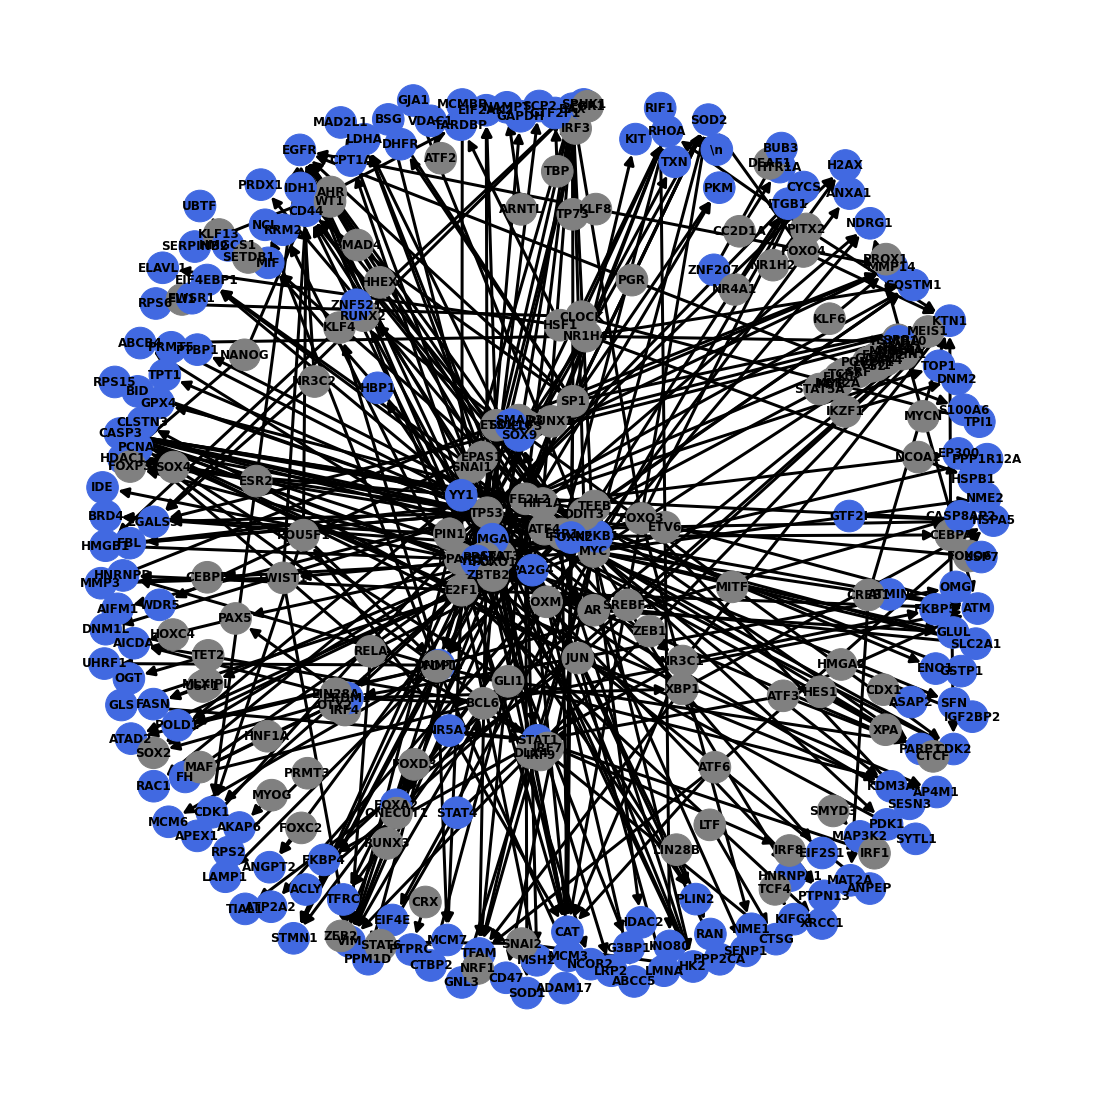

In [9]:
color_map = ["royalblue" if node not in latent_nodes else "grey" for node in G]
plt.figure(figsize=(15,15))
nx.draw(G, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000, node_color=color_map)
plt.show()

In [18]:
H = remove_latent_nodes(G, latent_nodes)

y0_graph = graph_builder(G, H)

In [21]:
queries = find_all_identifiable_pairs(y0_graph)

In [37]:
mel_input_data = msstats_mel_summarized.pivot(index='id', columns='Protein', values='Abundance')
mel_input_data = mel_input_data.reset_index(drop=True)
# mel_input_data.columns = np.array([uniprot_client.get_gene_name(x) for x in mel_input_data.columns])

In [38]:
mel_input_data

Protein,1433B,1433E,1433F,1433G,1433S,1433T,1433Z,2A5D,2AAA,2ABA,...,ZN879,ZNF56,ZNF66,ZNF84,ZPR1,ZRAB2,ZSC12,ZSWM8,ZYX,ZZEF1
0,12.041719,12.067474,9.931233,11.646565,NaN,10.483169,12.084597,NaN,10.824589,9.446688,...,NaN,10.162655,NaN,NaN,NaN,11.834094,NaN,NaN,11.277242,12.044238
1,11.168336,11.614204,10.526544,11.052942,NaN,9.227921,12.071602,NaN,10.638100,10.348553,...,NaN,10.092188,NaN,NaN,NaN,11.671651,NaN,NaN,NaN,12.898389
2,11.837160,11.984787,9.904276,11.245501,NaN,11.047630,11.640363,NaN,10.244684,NaN,...,NaN,NaN,NaN,NaN,NaN,11.764911,NaN,NaN,10.591087,12.471462
3,NaN,10.174148,NaN,9.275726,NaN,NaN,NaN,NaN,9.411332,NaN,...,NaN,NaN,NaN,NaN,NaN,11.278610,NaN,NaN,11.286733,8.985850
4,11.285667,11.361089,9.633487,11.088945,NaN,10.277019,11.920079,NaN,9.926974,NaN,...,NaN,NaN,NaN,NaN,NaN,11.926122,NaN,NaN,9.798842,12.261968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,11.492449,11.790002,9.531766,11.553462,NaN,10.673040,12.150075,NaN,10.685766,9.166039,...,NaN,9.322675,NaN,NaN,NaN,11.706517,NaN,NaN,11.220140,12.658093
309,11.542261,11.507381,8.456921,11.285339,NaN,10.300272,12.054665,NaN,9.926175,NaN,...,NaN,9.333371,NaN,NaN,NaN,11.645464,NaN,NaN,10.914117,13.905505
310,11.780123,11.601476,9.045228,10.998525,NaN,10.295987,12.017431,NaN,9.841908,NaN,...,NaN,10.044444,NaN,NaN,NaN,12.134165,NaN,NaN,10.248698,12.633479
311,11.978622,12.152781,9.640714,11.429982,NaN,10.015805,11.769215,NaN,8.958067,NaN,...,NaN,8.955331,NaN,NaN,NaN,11.746414,NaN,NaN,NaN,13.825652


## New Workflow

In [1]:
from single_cell_scm.causal_graph import CausalGraph
import pandas as pd
import networkx as nx
import itertools

from protmapper import uniprot_client

pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
# net1 = pd.read_csv("../Data/Indra/indra_networks/exploratory/indranet.tsv", sep="\t")
# net2 = pd.read_csv("../Data/Indra/indra_networks/MAPK/indranet.tsv", sep="\t")
# net3 = pd.read_csv("../Data/Indra/indra_networks/mapk_downstream/indranet.tsv", sep="\t")
# net = pd.concat([net1, net2, net3], ignore_index=True)
# net = net.loc[net["stmt_type"].isin(["Activation", "IncreaseAmount", "Inhibition", "DecreaseAmount"])]

net = pd.read_csv("../Data/Indra/indra_networks/mapk_downstream/net_no_cycles.tsv", sep="\t")

Build graph

In [16]:
causal_net = CausalGraph(net)

In [4]:
causal_net.indra_to_dag(["IncreaseAmount", "DecreaseAmount"], 
                       drop_bidirect_randomly=True)

In [15]:
def drop_edges(network):
    causal_net = CausalGraph(network)
    causal_net.indra_to_dag(["IncreaseAmount", "DecreaseAmount"], 
                       drop_bidirect_randomly=True)
    
    cycles = nx.simple_cycles(causal_net.full_graph)
    current_cycles = set([(i[0], i[-1]) for i in list(itertools.islice(cycles, 1))])
    
    if len(current_cycles) == 0:
        print("all cycles removed")
    else:
        for i in current_cycles:
            network = network[~((network["agA_name"].isin([i[0], i[1]])) & 
                                (network["agB_name"].isin([i[0], i[1]])))]
    return(network)


In [16]:
net_len = len(net)
old_net_len=len(net)+1
i=1
while net_len < old_net_len:
    old_net_len=len(net)
    net=drop_edges(net)
    net_len = len(net)
    i+=1
    

all cycles removed
46283
46283


In [3]:
causal_net = CausalGraph(net)
causal_net.indra_to_dag(["IncreaseAmount", "DecreaseAmount"], 
                   drop_bidirect_randomly=True)

In [34]:
len(causal_net.full_graph.nodes)

In [4]:
msstats_mel_summarized = pd.read_csv("../Data/Leduc/MSstats/MSstats_summarized.csv")
msstats_mel_feature = pd.read_csv("../Data/Leduc/MSstats/MSstats_mel_feature.csv")
annotation = pd.read_csv("../Data/Leduc/MS_results_data/meta.csv", index_col="Unnamed: 0")

# msstats_mon_summarized = pd.read_csv("../Data/Leduc/MSstats/msstats_mon_summarized.csv")
# msstats_mon_feature = pd.read_csv("../Data/Leduc/MSstats/msstats_mon_feature.csv")

## Add in info for join
annotation.loc[:, "channel_match"] = "channel" + annotation.loc[:, "channel"].str.split(".", expand=True)[2]
msstats_mel_summarized = pd.merge(msstats_mel_summarized, annotation, how="left", 
         left_on=["Mixture", "Channel", "Condition"],
         right_on=["digest", "channel_match", "celltype"])

msstats_mel_summarized = msstats_mel_summarized.loc[~msstats_mel_summarized["Protein"].str.contains(";")]
msstats_mel_summarized.loc[:, "Protein"] = msstats_mel_summarized.loc[:, "Protein"].str.split("|", expand=True)[1]
# msstats_mel_summarized.loc[:, "Protein"] = msstats_mel_summarized.loc[:, "Protein"].str.split("_", expand=True)[0]

In [5]:
input_data = msstats_mel_summarized.pivot(columns="Protein", values="Abundance", index="id")
input_data.columns = [uniprot_client.get_gene_name(x) for x in input_data.columns]

<AxesSubplot:>

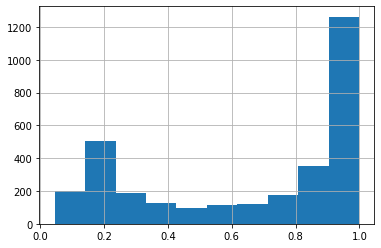

In [6]:
(input_data.isna().sum() / (input_data.count() + input_data.isna().sum())).hist()

In [7]:
keep = (input_data.isna().sum() / (input_data.count() + input_data.isna().sum()))[
    (input_data.isna().sum() / (input_data.count() + input_data.isna().sum())) < .34].index

In [8]:
parsed_input = input_data.loc[:, keep].fillna(input_data.loc[:, keep].mean())

In [9]:
causal_net.identify_latent_nodes(parsed_input)

In [10]:
len(causal_net.full_graph.nodes)

In [11]:
len(causal_net.latent_nodes)

In [12]:
from y0.algorithm.simplify_latent import simplify_latent_dag
import copy

In [13]:
simplified_graph = simplify_latent_dag(copy.deepcopy(causal_net.full_graph), "hidden")

In [14]:
simplified_graph.graph.nodes.data()

NodeDataView({'AADAC': {'hidden': True}, 'ABCD1': {'hidden': True}, 'ACE': {'hidden': True}, 'ACR': {'hidden': True}, 'ACSM3': {'hidden': True}, 'ADAM17': {'hidden': True}, 'ADAMTS12': {'hidden': True}, 'RHOA': {'hidden': False}, 'AGRP': {'hidden': True}, 'IGF2R': {'hidden': False}, 'SERPINB2': {'hidden': False}, 'AJUBA': {'hidden': True}, 'AKT1': {'hidden': True}, 'AKT2': {'hidden': True}, 'ALK': {'hidden': True}, 'ANPEP': {'hidden': True}, 'ANXA2': {'hidden': False}, 'ANXA5': {'hidden': False}, 'APC': {'hidden': True}, 'APEX1': {'hidden': False}, 'APOE': {'hidden': True}, 'PRKDC': {'hidden': False}, 'ARNT': {'hidden': True}, 'ATF2': {'hidden': True}, 'HSPA5': {'hidden': False}, 'ATG16L1': {'hidden': True}, 'ATM': {'hidden': True}, 'H2AX': {'hidden': False}, 'TRIM28': {'hidden': False}, 'ATR': {'hidden': True}, 'AURKA': {'hidden': True}, 'AURKB': {'hidden': True}, 'AVP': {'hidden': True}, 'BCAR1': {'hidden': True}, 'BMP7': {'hidden': True}, 'BRAF': {'hidden': True}, 'BRCA2': {'hidden'

In [45]:
len(causal_net.full_graph.nodes)

In [16]:
from y0.graph import NxMixedGraph

y0_graph = NxMixedGraph()
y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")

In [22]:
len(y0_graph.undirected.edges)

In [24]:
len(y0_graph.nodes())

In [27]:
len([i for i in itertools.combinations(y0_graph.nodes(), r=2)])

In [28]:
y0_graph.nodes()

NodeView((CDK1, STMN1, APEX1, FBL, PCNA, PSME3, TFAM, AIFM1, GAPDH, TPT1, SNCA, FASN, ELAVL1, HSPA5, TPI1, PEBP1, HCLS1, ENO1, GLS, RHOA, HSPD1, SERPINB2, CIRBP, CD44, MTDH, TNFSF13B, CTTN, FKBP5, LAMP1, LGALS9, MAT2A, LMNA, SQSTM1, SERPINH1, HMGA1, IGF2R, MCM7, HNRNPD, MSH2, PRKDC, RAN, HMGB1, ANXA2, NME2, HNRNPA1, GNL3, LDHA, PKM, ANXA5, H2AX, TRIM28, KHDRBS1, PDK1, MIF, TFRC, NME1, TXN, SOD1, BSG, HSPB1, PARP1, CDC42, CYCS, DBI, DDX3X, DDX5, EIF2S1, EZR, FH, FUBP1, GPI, GTF2I, H1-5, HDAC1, HNRNPK, HSPA9, LGALS1, LGALS3, RPS6, MMP3, MYH9, NCL, NPM1, PA2G4, PARK7, PLEC, PPIA, PPM1G, PRMT1, PRMT5, STAT1, RAC1, RACK1, RENBP, RPL26, S100A4, S100A6, CAT, PCBP2, TARDBP, TBCA, MCM3, MCM6, UBE2I, XPO1, XRCC6, YBX1, CDK2, MYDGF, NAMPT, PTMA))

In [49]:
from y0.identify import is_identifiable
from y0.algorithm.identify import Identification, identify

from y0.dsl import P, Variable

for pair in itertools.combinations(y0_graph.nodes(), r=2):
    print(pair)
    if is_identifiable(y0_graph, P(pair[0] @ pair[1])):
        query = Identification.from_expression(graph=y0_graph, query=P(pair[0] @ pair[1]))
        estimand = identify(query)
        print(estimand)

(CDK1, STMN1)


KeyboardInterrupt: 

In [71]:
y0_graph.ancestors_inclusive(Variable('STMN1'))

{ANXA2,
 CD44,
 DBI,
 DDX5,
 EIF2S1,
 FH,
 FUBP1,
 HDAC1,
 HMGB1,
 HNRNPK,
 HSPA9,
 MIF,
 MYDGF,
 NAMPT,
 NCL,
 NPM1,
 PA2G4,
 PARK7,
 PARP1,
 PKM,
 PPM1G,
 PRMT5,
 RAC1,
 RACK1,
 RENBP,
 RPL26,
 S100A4,
 STAT1,
 STMN1,
 TARDBP,
 TBCA,
 XPO1,
 YBX1}

In [43]:
[i for i in y0_graph.topological_sort()]

[ANXA2,
 ANXA5,
 H2AX,
 TRIM28,
 KHDRBS1,
 BSG,
 PARP1,
 CDC42,
 CYCS,
 DBI,
 DDX3X,
 DDX5,
 EIF2S1,
 EZR,
 FH,
 FUBP1,
 GPI,
 GTF2I,
 H1-5,
 HDAC1,
 HNRNPK,
 HSPA9,
 LGALS1,
 LGALS3,
 MMP3,
 MYH9,
 NCL,
 NPM1,
 PA2G4,
 PARK7,
 PLEC,
 PPIA,
 PPM1G,
 PRMT1,
 PRMT5,
 RAC1,
 RACK1,
 RENBP,
 RPL26,
 S100A4,
 S100A6,
 CAT,
 PCBP2,
 TARDBP,
 TBCA,
 MCM3,
 MCM6,
 UBE2I,
 XPO1,
 XRCC6,
 YBX1,
 CDK2,
 MYDGF,
 NAMPT,
 PTMA,
 TXN,
 SOD1,
 STAT1,
 PDK1,
 MIF,
 TFRC,
 NME1,
 HSPD1,
 CIRBP,
 CTTN,
 FKBP5,
 MTDH,
 NME2,
 HNRNPA1,
 GNL3,
 LDHA,
 RAN,
 PKM,
 LAMP1,
 CD44,
 RPS6,
 GLS,
 TNFSF13B,
 HMGB1,
 LGALS9,
 MAT2A,
 RHOA,
 LMNA,
 SERPINB2,
 SERPINH1,
 HMGA1,
 IGF2R,
 MCM7,
 HNRNPD,
 MSH2,
 PRKDC,
 HSPB1,
 SQSTM1,
 STMN1,
 APEX1,
 FBL,
 PCNA,
 PSME3,
 TFAM,
 AIFM1,
 CDK1,
 GAPDH,
 TPT1,
 SNCA,
 ELAVL1,
 TPI1,
 PEBP1,
 FASN,
 HCLS1,
 HSPA5,
 ENO1]

In [39]:
for i in y0_graph.nodes():
    if 

NodeView((CDK1, STMN1, APEX1, FBL, PCNA, PSME3, TFAM, AIFM1, GAPDH, TPT1, SNCA, FASN, ELAVL1, HSPA5, TPI1, PEBP1, HCLS1, ENO1, GLS, RHOA, HSPD1, SERPINB2, CIRBP, CD44, MTDH, TNFSF13B, CTTN, FKBP5, LAMP1, LGALS9, MAT2A, LMNA, SQSTM1, SERPINH1, HMGA1, IGF2R, MCM7, HNRNPD, MSH2, PRKDC, RAN, HMGB1, ANXA2, NME2, HNRNPA1, GNL3, LDHA, PKM, ANXA5, H2AX, TRIM28, KHDRBS1, PDK1, MIF, TFRC, NME1, TXN, SOD1, BSG, HSPB1, PARP1, CDC42, CYCS, DBI, DDX3X, DDX5, EIF2S1, EZR, FH, FUBP1, GPI, GTF2I, H1-5, HDAC1, HNRNPK, HSPA9, LGALS1, LGALS3, RPS6, MMP3, MYH9, NCL, NPM1, PA2G4, PARK7, PLEC, PPIA, PPM1G, PRMT1, PRMT5, STAT1, RAC1, RACK1, RENBP, RPL26, S100A4, S100A6, CAT, PCBP2, TARDBP, TBCA, MCM3, MCM6, UBE2I, XPO1, XRCC6, YBX1, CDK2, MYDGF, NAMPT, PTMA))

In [66]:
len(y0_graph.nodes())

In [100]:
confounders = y0_graph.undirected.edges(Variable('STMN1'))

In [101]:
confounders

EdgeDataView([(STMN1, CDK1), (STMN1, APEX1), (STMN1, FBL), (STMN1, PCNA), (STMN1, PSME3), (STMN1, TFAM), (STMN1, AIFM1), (STMN1, GAPDH), (STMN1, TPT1), (STMN1, SNCA), (STMN1, FASN), (STMN1, ELAVL1), (STMN1, HSPA5), (STMN1, TPI1), (STMN1, PEBP1), (STMN1, HCLS1), (STMN1, ENO1), (STMN1, GLS), (STMN1, RHOA), (STMN1, HSPD1), (STMN1, SERPINB2), (STMN1, CIRBP), (STMN1, CD44), (STMN1, MTDH), (STMN1, TNFSF13B), (STMN1, CTTN), (STMN1, FKBP5), (STMN1, LAMP1), (STMN1, LGALS9), (STMN1, MAT2A), (STMN1, LMNA), (STMN1, SQSTM1), (STMN1, SERPINH1), (STMN1, HMGA1), (STMN1, IGF2R), (STMN1, MCM7), (STMN1, HNRNPD), (STMN1, MSH2), (STMN1, PRKDC), (STMN1, RAN), (STMN1, HMGB1), (STMN1, NME2), (STMN1, HNRNPA1), (STMN1, GNL3), (STMN1, LDHA), (STMN1, PKM), (STMN1, H2AX), (STMN1, TRIM28), (STMN1, ANXA2), (STMN1, KHDRBS1), (STMN1, PDK1), (STMN1, MIF), (STMN1, TFRC), (STMN1, NME1), (STMN1, TXN), (STMN1, SOD1), (STMN1, PARP1), (STMN1, HSPB1), (STMN1, EIF2S1), (STMN1, RPS6), (STMN1, CAT), (STMN1, MCM3), (STMN1, MCM6),

In [93]:
import pyro
import pyro.distributions as dist


In [97]:
test=dict()
for e in confounders:
    test[e] =  pyro.sample("b_{}".format(e), dist.Normal(0., 1.))

In [103]:
ordered_nodes = [i for i in y0_graph.topological_sort()]
for i in range(len(ordered_nodes)):
    print(ordered_nodes[i])

ANXA2
ANXA5
H2AX
TRIM28
KHDRBS1
BSG
PARP1
CDC42
CYCS
DBI
DDX3X
DDX5
EIF2S1
EZR
FH
FUBP1
GPI
GTF2I
H1-5
HDAC1
HNRNPK
HSPA9
LGALS1
LGALS3
MMP3
MYH9
NCL
NPM1
PA2G4
PARK7
PLEC
PPIA
PPM1G
PRMT1
PRMT5
RAC1
RACK1
RENBP
RPL26
S100A4
S100A6
CAT
PCBP2
TARDBP
TBCA
MCM3
MCM6
UBE2I
XPO1
XRCC6
YBX1
CDK2
MYDGF
NAMPT
PTMA
TXN
SOD1
STAT1
PDK1
MIF
TFRC
NME1
HSPD1
CIRBP
CTTN
FKBP5
MTDH
NME2
HNRNPA1
GNL3
LDHA
RAN
PKM
LAMP1
CD44
RPS6
GLS
TNFSF13B
HMGB1
LGALS9
MAT2A
RHOA
LMNA
SERPINB2
SERPINH1
HMGA1
IGF2R
MCM7
HNRNPD
MSH2
PRKDC
HSPB1
SQSTM1
STMN1
APEX1
FBL
PCNA
PSME3
TFAM
AIFM1
CDK1
GAPDH
TPT1
SNCA
ELAVL1
TPI1
PEBP1
FASN
HCLS1
HSPA5
ENO1


In [105]:
confounders = y0_graph.undirected.edges(Variable('STMN1'))

In [107]:
len(confounders)

In [ ]:
causal_net.create_latent_graph()

In [142]:
undirected_edges = y0_graph.undirected.edges()
for e in undirected_edges:
    print(tuple(sorted(e)))

(CDK1, STMN1)
(APEX1, CDK1)
(CDK1, FBL)
(CDK1, PCNA)
(CDK1, PSME3)
(CDK1, TFAM)
(AIFM1, CDK1)
(CDK1, GAPDH)
(CDK1, TPT1)
(CDK1, SNCA)
(CDK1, FASN)
(CDK1, ELAVL1)
(CDK1, HSPA5)
(CDK1, TPI1)
(CDK1, PEBP1)
(CDK1, HCLS1)
(CDK1, ENO1)
(CDK1, GLS)
(CDK1, RHOA)
(CDK1, HSPD1)
(CDK1, SERPINB2)
(CDK1, CIRBP)
(CD44, CDK1)
(CDK1, MTDH)
(CDK1, TNFSF13B)
(CDK1, CTTN)
(CDK1, FKBP5)
(CDK1, LAMP1)
(CDK1, LGALS9)
(CDK1, MAT2A)
(CDK1, LMNA)
(CDK1, SQSTM1)
(CDK1, SERPINH1)
(CDK1, HMGA1)
(CDK1, IGF2R)
(CDK1, MCM7)
(CDK1, HNRNPD)
(CDK1, MSH2)
(CDK1, PRKDC)
(CDK1, RAN)
(CDK1, HMGB1)
(CDK1, NME2)
(CDK1, HNRNPA1)
(CDK1, GNL3)
(CDK1, LDHA)
(CDK1, PKM)
(CDK1, H2AX)
(CDK1, TRIM28)
(ANXA2, CDK1)
(CDK1, KHDRBS1)
(CDK1, PDK1)
(CDK1, MIF)
(CDK1, TFRC)
(CDK1, NME1)
(CDK1, TXN)
(CDK1, SOD1)
(CDK1, PARP1)
(CDK1, HSPB1)
(CDK1, EIF2S1)
(CDK1, RPS6)
(CAT, CDK1)
(CDK1, MCM3)
(CDK1, MCM6)
(CDK1, NCL)
(CDK1, CDK2)
(CDK1, STAT1)
(APEX1, STMN1)
(FBL, STMN1)
(PCNA, STMN1)
(PSME3, STMN1)
(STMN1, TFAM)
(AIFM1, STMN1)
(GAPDH, STMN1

In [220]:
def generate_model(data, graph):
    
    ordered_nodes = [i for i in graph.topological_sort()]
    undirected_edges = graph.undirected.edges()
    
    beta_coefficients = dict()
    confounder_coefficients = dict()
    sigma_coefficients = dict()
    confounder_sigma_coefficients = dict()
    
    for i in range(len(ordered_nodes)):
        ancesters = graph.ancestors_inclusive(ordered_nodes[i])
        confounders = graph.undirected.edges(ordered_nodes[i])
        
        sigma_coefficients[ordered_nodes[i]] = pyro.sample(
                "sigma_{}".format(ordered_nodes[i]), dist.Uniform(0., 5.))
        
        betas = dict()
        if len(ancesters) > 1:    
            for upstream in ancesters:
                if upstream != ordered_nodes[i]:
                    betas[upstream] = pyro.sample(
                        "b_{0}_{1}".format(ordered_nodes[i], upstream), 
                        dist.Normal(0., 1.))
        beta_coefficients[ordered_nodes[i]] = betas
        if len(confounders)> 0: 
            for e in confounders:
                confounder_coefficients[tuple(sorted(e))] =  pyro.sample("b_{0}_{1}".format(ordered_nodes[i], 
                                                                                            tuple(sorted(e))), 
                                                                         dist.Normal(0., 1.))
        
    
    for e in undirected_edges:
        confounder_sigma_coefficients[tuple(sorted(e))] =  pyro.sample("sigma_{}".format(tuple(sorted(e))), dist.Uniform(0., 5.))
    
    with pyro.plate("data", len(data)):
        latent_variables = dict()
        observed_variables = dict()
        
        for e in undirected_edges:
            latent_variables[tuple(sorted(e))] = pyro.sample("latent_{}".format(tuple(sorted(e))), 
                                              dist.Normal(0, confounder_sigma_coefficients[tuple(sorted(e))]))
            
        for i in range(len(ordered_nodes)):
            ancesters = graph.ancestors_inclusive(ordered_nodes[i])
            confounders = graph.undirected.edges(ordered_nodes[i])
            temp_mean = 0
            if len(confounders) > 0:
                for e in confounders:
                    temp_mean += confounder_coefficients[tuple(sorted(e))]*latent_variables[tuple(sorted(e))]
                    
            if len(ancesters) > 1:
                for upstream in ancesters:
                    if upstream != ordered_nodes[i]:
                        temp_mean += beta_coefficients[ordered_nodes[i]][upstream]*observed_variables[upstream]

            observed_variables[ordered_nodes[i]] = pyro.sample("obs_{}".format(ordered_nodes[i]), 
                                                               dist.Normal(temp_mean, 
                                                                           sigma_coefficients[ordered_nodes[i]]), 
                                                               obs=torch.tensor(data.loc[:, str(ordered_nodes[i])].values))
    

In [221]:
def generate_guide(data, graph):
    
    ordered_nodes = [i for i in graph.topological_sort()]
    undirected_edges = graph.undirected.edges()
    
    confounder_sigma_coefficients = dict()
    
    for i in range(len(ordered_nodes)):
        ancesters = graph.ancestors_inclusive(ordered_nodes[i])
        confounders = graph.undirected.edges(ordered_nodes[i])
                
        temp_sigma_loc = pyro.param("sigma_loc_{}".format(ordered_nodes[i]), torch.tensor(1.), 
                   constraint=constraints.positive)
        pyro.sample("sigma_{}".format(ordered_nodes[i]), dist.Normal(temp_sigma_loc, torch.tensor(0.05)))
        
        if len(ancesters) > 1:    
            for upstream in ancesters:
                if upstream != ordered_nodes[i]:
                    temp_b_loc = pyro.param("b_loc_{0}_{1}".format(ordered_nodes[i], upstream), torch.tensor(0.))
                    pyro.sample("b_{0}_{1}".format(ordered_nodes[i], upstream), dist.Normal(temp_b_loc, .1))
        if len(confounders)> 0: 
            for e in confounders:
                
                temp_b_loc = pyro.param("b_loc_{0}_{1}".format(ordered_nodes[i], 
                                                               tuple(sorted(e))), 
                                        torch.tensor(0.))
                pyro.sample("b_{0}_{1}".format(ordered_nodes[i], tuple(sorted(e))), 
                            dist.Normal(temp_b_loc, 1.))
    
    for e in undirected_edges:
        temp_sigma_loc = pyro.param("sigma_loc_{}".format(tuple(sorted(e))), torch.tensor(1.), 
                   constraint=constraints.positive)
        confounder_sigma_coefficients[tuple(sorted(e))] = pyro.sample("sigma_{}".format(tuple(sorted(e))), 
                                                                      dist.Normal(temp_sigma_loc, torch.tensor(0.05)))
    
    with pyro.plate("data", len(data)):

        for e in undirected_edges:
            pyro.sample("latent_{}".format(tuple(sorted(e))), 
                        dist.Normal(0, confounder_sigma_coefficients[tuple(sorted(e))]))

In [223]:
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
from torch.distributions import constraints
import torch

svi = SVI(generate_model,
          generate_guide,
          optim.Adam({"lr": .001}),
          loss=Trace_ELBO())

pyro.clear_param_store()
for i in range(2000):
    elbo = svi.step(causal_net.experimental_data, causal_net.causal_graph)
    if i % 10 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 6824684.234720947
Elbo loss: 6163936.030997718
Elbo loss: 5576895.634124129
Elbo loss: 5206394.097358077
Elbo loss: 4888827.170941649
Elbo loss: 4534129.0380964335
Elbo loss: 4553860.226724108
Elbo loss: 4215639.877112306
Elbo loss: 4046300.4342809096
Elbo loss: 4144476.476408598
Elbo loss: 3876448.7157080257
Elbo loss: 3753568.9457687614
Elbo loss: 3768271.5374021586
Elbo loss: 3645253.779106457
Elbo loss: 3654689.815225114
Elbo loss: 3721692.6089659333
Elbo loss: 3453710.791993941
Elbo loss: 3341882.8067472996
Elbo loss: 3163605.282912004
Elbo loss: 3274169.81378146
Elbo loss: 3129565.2336746315
Elbo loss: 3155370.247381393
Elbo loss: 3244273.6656933157
Elbo loss: 2938676.3075056644
Elbo loss: 3027557.3524891036
Elbo loss: 2952454.464272457
Elbo loss: 2886000.4052310046
Elbo loss: 2799936.8686820427
Elbo loss: 2676736.8630292164
Elbo loss: 2711866.854521591
Elbo loss: 2733709.348147422
Elbo loss: 2545215.0830631377
Elbo loss: 2466925.668746216
Elbo loss: 2550715.0504232477

In [224]:
def inf_model(data, graph):
        
    ordered_nodes = [i for i in graph.topological_sort()]
    undirected_edges = graph.undirected.edges()
    
    beta_coefficients = dict()
    confounder_coefficients = dict()
    sigma_coefficients = dict()
    confounder_sigma_coefficients = dict()
    
    for i in range(len(ordered_nodes)):
        ancesters = graph.ancestors_inclusive(ordered_nodes[i])
        confounders = graph.undirected.edges(ordered_nodes[i])
        
        sigma_coefficients[ordered_nodes[i]] = pyro.get_param_store()[
            "sigma_loc_{}".format(ordered_nodes[i])].detach()
        
        
        betas = dict()
        if len(ancesters) > 1:    
            for upstream in ancesters:
                if upstream != ordered_nodes[i]:
                    betas[upstream] = pyro.get_param_store()[
                        "b_loc_{0}_{1}".format(ordered_nodes[i], upstream)].detach()
        beta_coefficients[ordered_nodes[i]] = betas
        if len(confounders)> 0: 
            for e in confounders:
                confounder_coefficients[tuple(sorted(e))] = pyro.get_param_store()[
                        "b_loc_{0}_{1}".format(ordered_nodes[i], tuple(sorted(e)))].detach()
    
    for e in undirected_edges:
        confounder_sigma_coefficients[tuple(sorted(e))] =  pyro.get_param_store()[
            "sigma_loc_{}".format(tuple(sorted(e)))].detach()
    
    latent_variables = dict()
    observed_variables = dict()

    for e in undirected_edges:
        latent_variables[tuple(sorted(e))] = pyro.sample("latent_{}".format(tuple(sorted(e))), 
                                          dist.Normal(0, confounder_sigma_coefficients[tuple(sorted(e))]))

    for i in range(len(ordered_nodes)):
        ancesters = graph.ancestors_inclusive(ordered_nodes[i])
        confounders = graph.undirected.edges(ordered_nodes[i])
        temp_mean = 0
        if len(confounders) > 0:
            for e in confounders:
                temp_mean += confounder_coefficients[tuple(sorted(e))]*latent_variables[tuple(sorted(e))]

        if len(ancesters) > 1:
            for upstream in ancesters:
                if upstream != ordered_nodes[i]:
                    temp_mean += beta_coefficients[ordered_nodes[i]][upstream]*observed_variables[upstream]

        observed_variables[ordered_nodes[i]] = pyro.sample("obs_{}".format(ordered_nodes[i]), 
                                                           dist.Normal(temp_mean, 
                                                                       sigma_coefficients[ordered_nodes[i]]))
    return observed_variables

In [225]:
inf_model(causal_net.experimental_data, causal_net.causal_graph)

{ANXA2: tensor(1.4829),
 ANXA5: tensor(2.6734),
 H2AX: tensor(3.9334),
 TRIM28: tensor(3.5503),
 BSG: tensor(0.7267),
 PARP1: tensor(1.4882),
 CDC42: tensor(-0.1691),
 DBI: tensor(2.7532),
 DDX3X: tensor(-4.0132),
 DDX5: tensor(-2.5054),
 EIF2S1: tensor(-0.4559),
 EZR: tensor(0.3516),
 FH: tensor(0.7041),
 FUBP1: tensor(-0.4644),
 GPI: tensor(-1.2923),
 GTF2I: tensor(-0.1239),
 H1-5: tensor(-0.3872),
 HDAC1: tensor(-1.5318),
 HNRNPK: tensor(-1.8173),
 HSPA9: tensor(6.8364),
 LGALS1: tensor(1.6771),
 LGALS3: tensor(-3.3932),
 KHDRBS1: tensor(-2.9971),
 MMP3: tensor(-3.7124),
 MYH9: tensor(-4.5072),
 NPM1: tensor(-0.0946),
 PA2G4: tensor(3.1533),
 PARK7: tensor(3.8488),
 PLEC: tensor(3.0862),
 PPIA: tensor(-1.9628),
 PPM1G: tensor(-1.0538),
 PRMT1: tensor(-2.9314),
 PRMT5: tensor(-0.0806),
 RAC1: tensor(-4.2432),
 RACK1: tensor(2.4039),
 RENBP: tensor(-2.0785),
 RPL26: tensor(-1.1378),
 S100A4: tensor(-2.7866),
 S100A6: tensor(3.4473),
 CAT: tensor(3.2471),
 PCBP2: tensor(0.3322),
 TARDB

In [210]:
import pickle
with open(r"/mnt/d/Northeastern/Research/Causal_Inference/Applications_Project/packages/single_cell_scm/models/leduc_graph.pkl", "rb") as input_file:
    causal_net = pickle.load(input_file)

In [212]:
print(len(causal_net.identified_edges["Identifiable"]))
print(len(causal_net.identified_edges["NonIdentifiable"]))

11951
259


In [218]:
causal_net.identified_edges["Identifiable"]

[(CDK1, SERPINB2),
 (SERPINB2, CDK1),
 (CDK1, PRKDC),
 (PRKDC, CDK1),
 (CDK1, HSPA5),
 (HSPA5, CDK1),
 (CDK1, APEX1),
 (APEX1, CDK1),
 (CDK1, PSME3),
 (PSME3, CDK1),
 (CDK1, FBL),
 (FBL, CDK1),
 (CDK1, STMN1),
 (STMN1, CDK1),
 (CDK1, TFAM),
 (TFAM, CDK1),
 (CDK1, AIFM1),
 (AIFM1, CDK1),
 (CDK1, PCNA),
 (PCNA, CDK1),
 (CDK1, TPT1),
 (TPT1, CDK1),
 (CDK1, GAPDH),
 (GAPDH, CDK1),
 (CDK1, FASN),
 (FASN, CDK1),
 (CDK1, TPI1),
 (TPI1, CDK1),
 (CDK1, ELAVL1),
 (ELAVL1, CDK1),
 (CDK1, PEBP1),
 (PEBP1, CDK1),
 (CDK1, HCLS1),
 (HCLS1, CDK1),
 (CDK1, ENO1),
 (ENO1, CDK1),
 (CDK1, GLS),
 (GLS, CDK1),
 (CDK1, MTDH),
 (MTDH, CDK1),
 (CDK1, RHOA),
 (RHOA, CDK1),
 (CDK1, CIRBP),
 (CIRBP, CDK1),
 (TNFSF13B, CDK1),
 (CD44, CDK1),
 (CDK1, HSPD1),
 (HSPD1, CDK1),
 (CDK1, CTTN),
 (CTTN, CDK1),
 (CDK1, FKBP5),
 (FKBP5, CDK1),
 (CDK1, CYCS),
 (CYCS, CDK1),
 (CDK1, LGALS9),
 (LGALS9, CDK1),
 (CDK1, MAT2A),
 (MAT2A, CDK1),
 (CDK1, SNCA),
 (SNCA, CDK1),
 (CDK1, LMNA),
 (LMNA, CDK1),
 (CDK1, SQSTM1),
 (SQSTM1, C

In [230]:
import numpy as np

In [237]:
def ace(model, network, int_node, output_node):
    int_model1 = pyro.do(model, data={Variable(int_node): torch.tensor(1.)})
    Y_samples_1 = [int_model1(network.experimental_data, network.causal_graph)[
        Variable(output_node)].detach().numpy() for _ in range(1000)]

    int_model0 = pyro.do(model, data={Variable(int_node): torch.tensor(0.)})
    Y_samples_0 = [int_model0(network.experimental_data, network.causal_graph)[
        Variable(output_node)].detach().numpy() for _ in range(1000)]
    
    return(np.mean(Y_samples_1) - np.mean(Y_samples_0))

In [239]:
%timeit ace(inf_model, causal_net, "CDK1", "SERPINB2")

9min 32s ± 27.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [242]:
nx.shortest_path(causal_net.full_graph, "SERPINB2", "CDK1")

NetworkXNoPath: No path between SERPINB2 and CDK1.